## Setup

In [69]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
#import statsmodels.api as sm
# import itertools
import warnings
## Pyramid ARIMA
from pmdarima import auto_arima
# import pmdarima
import pickle

In [70]:
## Data
df = pd.read_csv("../0.Data/031381302.csv", index_col = "time")

# Check
print(df.shape)

## Time Series of interest
lightcurve = df.loc[:, ["pdcsap_flux"]]
lightcurve.sort_index(inplace=True)

# Check
print(lightcurve.shape); lightcurve.info(); lightcurve.head()

(17719, 23)
(17719, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 276.9 KB


,pdcsap_flux
time,
1437.978646,NaN
1437.980034,NaN
1437.981423,NaN
1437.982812,NaN
1437.984201,NaN


# SARIMA Imputation

In [71]:
# ## BASE CODE ##
# 
# ## Time Differences (2-min cadence)
# time_diffs = lightcurve.index.to_series().diff()

# ## Setup
# lc_fill = lightcurve.copy()
# med = time_diffs.median()
# cur = 1

# ## Iteratively add indices where missing
# for k, id in enumerate(lightcurve.index):
#     if k == 0: continue
#     # print(k, id)
#     diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
#     diff_size = diff / med
#     if diff_size < 2:
#         pass
#     elif (diff_size >= 2) & (diff_size < 3):
#         newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = [id - med])
#         lc_fill = pd.concat([lc_fill, newRows])
#     else:
#         newInds = np.arange(start = lightcurve.index[k - 1] + med, stop = id - med, step = med)
#         newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = newInds)
#         lc_fill = pd.concat([lc_fill, newRows])

# ## Cleanup
# lc_fill.sort_index(inplace = True)

In [72]:
# ## ROUGH WORK ##
# lightcurve.columns[0]

# pd.DataFrame({lightcurve.columns[0]: np.nan}, index = [1])

In [73]:
def fill_times(series):
    ## Time Differences
    time_diffs = series.index.to_series().diff()

    ## Setup
    series_fill = series.copy()
    med = time_diffs.median()

    ## Iteration
    for k, id in enumerate(series.index):
        if k == 0: continue
        # print(k, id)
        diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
        diff_size = diff / med
        if diff_size < 2:
            pass
        elif (diff_size >= 2) & (diff_size < 3):
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = [id - med])
            series_fill = pd.concat([series_fill, new_rows])
        else:
            new_inds = np.arange(start = series.index[k - 1] + med, stop = id - med, step = med)
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = new_inds)
            series_fill = pd.concat([series_fill, new_rows])

    ## Cleanup
    series_fill.sort_index(inplace = True)

    return series_fill

(18856, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 284.8 KB
None
Float64Index([1438.9564169769565, 1441.0230735546481,  1441.024462437205,
               1441.025851319762,  1441.027240202319],
             dtype='float64')
(1196,)


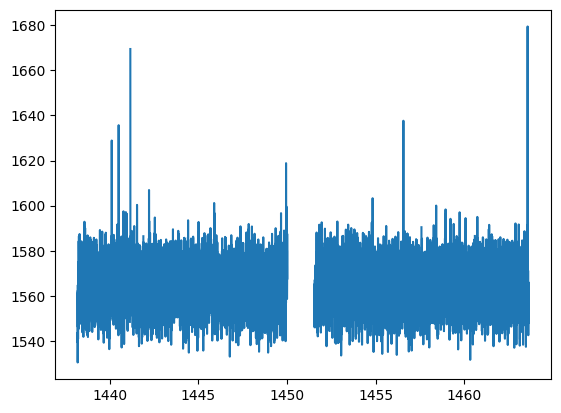

In [74]:
## Fill indices
lc_fill = fill_times(lightcurve)
print(lc_fill.shape)
print(lc_fill.info())

## Remove edge null indices
min_ind = lc_fill.dropna().index.min()
max_ind = lc_fill.dropna().index.max()
lc_fill = lc_fill.loc[min_ind:max_ind]
print(lc_fill.info())

## Identify null_indices
null_indices = lc_fill.iloc[np.where(lc_fill.isna())[0]].index
print(null_indices[0:5])
print(null_indices.shape)

## Check
plt.plot(lc_fill)

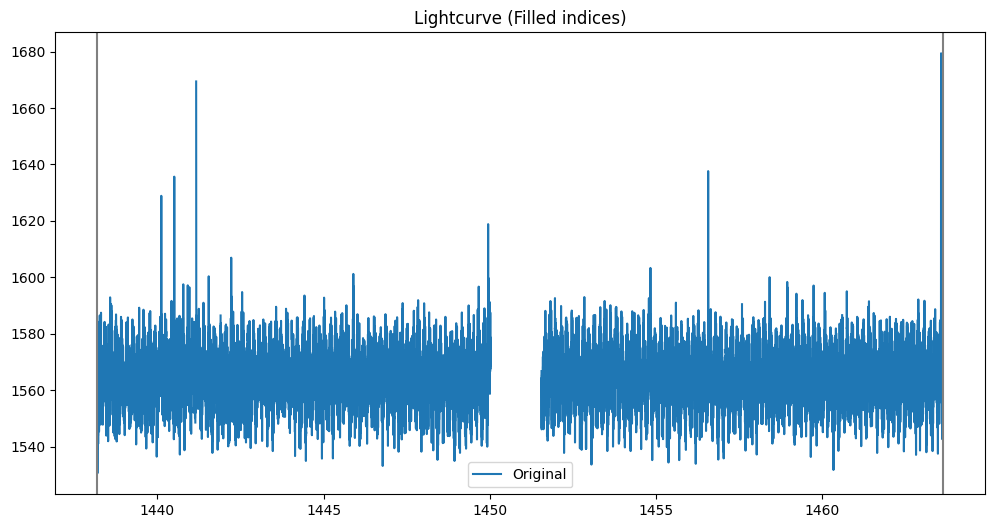

In [75]:
## Check
# Plot
plt.figure(figsize=(12,6))
plt.plot(lc_fill, label='Original')
plt.axvline(lc_fill.index.max(), color = "grey")
plt.axvline(lc_fill.index.min(), color = "grey")
plt.title("Lightcurve (Filled indices)")
plt.legend()
plt.show()

In [76]:
## Cut down
# lc_fill = lc_fill.iloc[0:1000]
# lc_fill = lc_fill.query("1447 <= index < 1453")
# lc_fill.shape

### Initial Imputation

In [77]:
## Temp impute
# lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())
# print(lc_interp.shape)

In [78]:
# lc_spline = lc_fill.interpolate(method = "spline", order = 5)
# print(lc_spline.info())

In [79]:
# lc_linear = lc_fill.interpolate(method='linear')
# print(lc_linear.info())

In [80]:
# lc_spline.fillna(method='bfill', inplace=True)
# print(lc_spline.info())

In [81]:
lc_interp = lc_fill.interpolate(method='pchip')
## Notes:
# 'krogh' doesn't work
# 'akima' interesting
# 'pchip' very interesting - 1-D monotonic cubic spline interpolation.
#   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.pchip_interpolate.html
#   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator
print(lc_interp.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  18229 non-null  float64
dtypes: float64(1)
memory usage: 284.8 KB
None


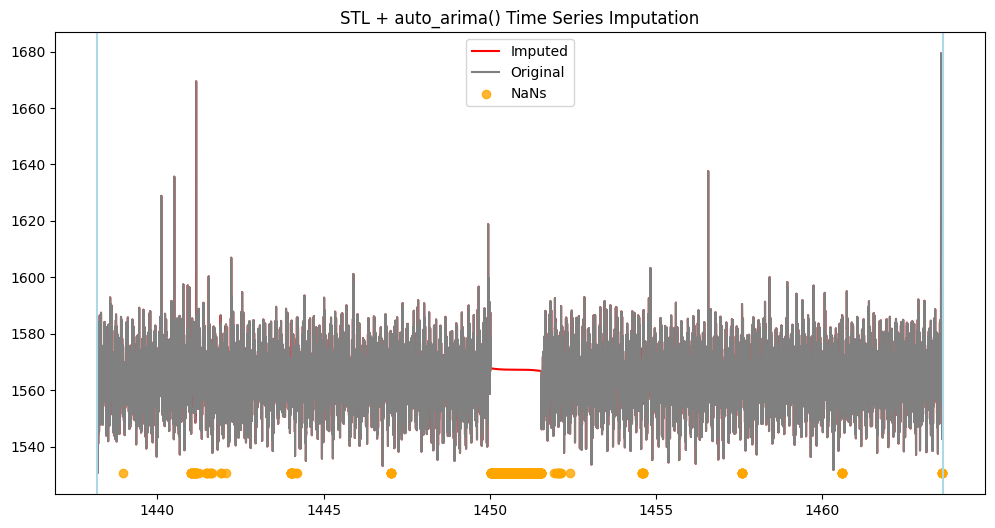

In [82]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_interp, label='Imputed', color = "red")
plt.plot(lc_fill, label='Original', color = "grey")
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange', alpha=0.8)
plt.axvline(lc_fill.index.max(), color = "lightblue")
plt.axvline(lc_fill.index.min(), color = "lightblue")
plt.title("STL + auto_arima() Time Series Imputation")
# plt.xlim((1449.5, 1452))
plt.legend()
plt.show()

### Model Imputation

In [ ]:
## LOG ##
## seasonal_periods=[240] (pchip pre-impute)
# AIC: 252868.104796

In [16]:
## TBATS ##
from tbats import TBATS, BATS

# Fit the model
estimator = TBATS(seasonal_periods=[240])
model_tbats = estimator.fit(lc_interp)

In [17]:
print(model_tbats.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [240.]
Seasonal harmonics [2]
ARMA errors (p, q): (1, 1)
Smoothing (Alpha): 0.016155
Seasonal Parameters (Gamma): [0.01734305 0.00501313]
AR coefficients [0.00501313]
MA coefficients [0.04307876]
Seed vector [ 1.55220796e+03  1.50782648e-01 -5.43392231e-01 -1.42519322e-01
 -6.67219672e-01  0.00000000e+00  0.00000000e+00]

AIC 252868.104796


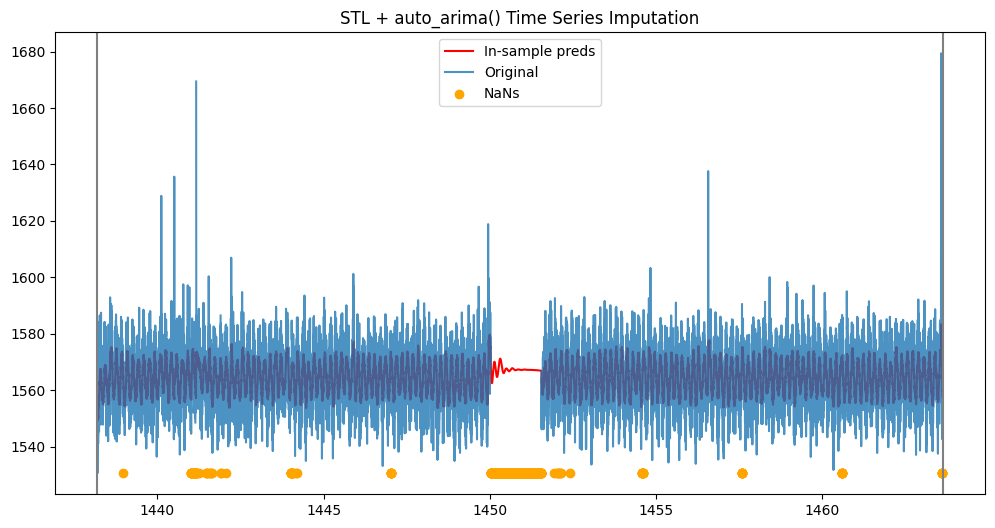

In [20]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_fill.index, model_tbats.y_hat, label='In-sample preds', color='red')
plt.plot(lc_fill, label='Original', alpha=0.8)
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
plt.axvline(lc_fill.index.max(), color = "grey")
plt.axvline(lc_fill.index.min(), color = "grey")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
# plt.xlim((1440, 1441))
plt.show()

In [ ]:
## LOG ##

## Run #2: lc_fill = lc_fill.query("1447 <= index < 1453")
# Best model:  ARIMA(4,0,4)(0,0,0)[5] intercept
# Total fit time: 1049.476 seconds
# Selected model order: (4, 0, 4) Seasonal order: (0, 0, 0, 5)

## Run #3: lc_fill = lc_fill.iloc[0:1000]
# Output before cutoff:
# Performing stepwise search to minimize aic
#  ARIMA(2,0,2)(1,0,1)[240] intercept   : AIC=inf, Time=1022.02 sec
#  ARIMA(0,0,0)(0,0,0)[240] intercept   : AIC=7135.422, Time=0.14 sec
#  ARIMA(1,0,0)(1,0,0)[240] intercept   : AIC=6972.780, Time=598.01 sec
#  ARIMA(0,0,1)(0,0,1)[240] intercept   : AIC=inf, Time=122.76 sec
#  ARIMA(0,0,0)(0,0,0)[240]             : AIC=17549.825, Time=0.02 sec
#  ARIMA(1,0,0)(0,0,0)[240] intercept   : AIC=6978.853, Time=0.15 sec

In [ ]:
## auto_arima
## Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Auto ARIMA
model_auto = auto_arima(
    lc_interp,
    start_p = 1, start_q = 1,
    d = 1,                      # d = 0 based on EDA
    max_p = 3, max_q = 3,
    start_P = 2, start_Q = 1,
    D = 1,
    max_P = 3, max_Q = 3,
    seasonal = True,
    m = 240,                    # m = number of periods in each season (Season = 1 day = 720 obs., Period = 240 obs. from EDA)
    stepwise = True,
    trace = True,
    suppress_warnings = True,
    error_action = "ignore"
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

Performing stepwise search to minimize aic


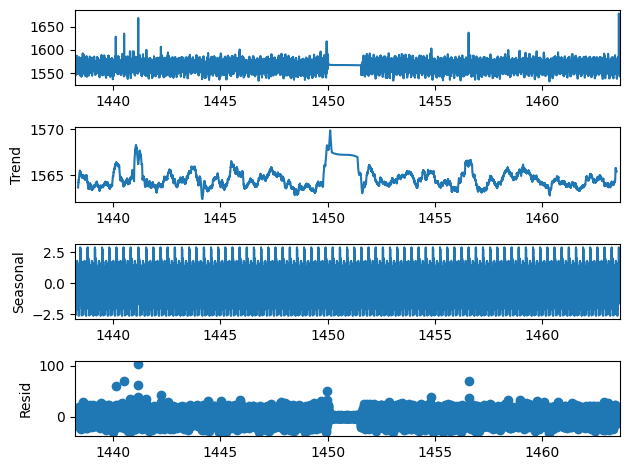

In [ ]:
## ROUGH WORK ##
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
# lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())
result = seasonal_decompose(lc_interp, model='additive', period=240)
result.plot()
plt.show()

In [ ]:
## BASE CODE ##
from statsmodels.tsa.statespace.sarimax import SARIMAX

## ChatGPT recommendations:
# p = 1, d = 1, q = 1
# P = 2, D = 1, Q = 1, s = 240
# d = 0 from ADF test
p, d, q = 1, 0, 1
P, D, Q, s = 2, 1, 1, 240

model = SARIMAX(
    lc_interp,
    order = (p, d, q),
    seasonal_order = (P, D, Q, s),
    enforce_stationarity = False,
    enforce_invertibility = False
)

sarimax_results = model.fit()

In [ ]:
# results = model_auto.fit()

# print(results.summary())

NameError: name 'model_auto' is not defined

In [ ]:
## LOG ##
## basic (no exog)
# AIC: 130442.96071380268

## four_orders = 1 (mean pre-impute)
# AIC: 130593.5500357342

## four_orders = 2 (mean pre-impute)
# AIC: 130473.3564172449

## four_orders = 3 (mean pre-impute)
# AIC: 130628.79894223655

## four_orders = 2 (pchip pre-impute)
# AIC: 126876.94453130582 #126787.38978664986 #126711.22170307473 #126688.10338482051

## four_orders = 1 (pchip pre-impute)
# AIC: 126649.52854652634

## four_orders = 3 (pchip pre-impute)
# AIC: 126650.5003115386

In [85]:
## ARIMA with Fourier terms ##
## Fourier terms
from pmdarima.preprocessing import FourierFeaturizer

four_order = 1
fourier_terms = FourierFeaturizer(240, four_order)
y_prime, exog = fourier_terms.fit_transform(lc_interp)
exog['time'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['time'])
exog = exog.drop(columns=['time'])
print(y_prime.head()); print(exog.head())
print((y_prime.shape, exog.shape))

             pdcsap_flux
1438.198088    1561.9932
1438.199477    1530.5082
1438.200866    1534.7330
1438.202255    1558.9431
1438.203644    1553.7203
             FOURIER_S240-0  FOURIER_C240-0
time                                       
1438.198088        0.026177        0.999657
1438.199477        0.052336        0.998630
1438.200866        0.078459        0.996917
1438.202255        0.104528        0.994522
1438.203644        0.130526        0.991445
((18229, 1), (18229, 2))


In [9]:
## auto_arima
## Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Auto ARIMA
model_auto = auto_arima(
    y_prime,
    X=exog,
    start_p = 12, start_q = 0,
    max_p = 20, max_q = 20,
    trace=True,
    error_action='ignore'
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(12,0,0)(0,0,0)[0] intercept   : AIC=126649.529, Time=15.93 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=132098.110, Time=1.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129732.563, Time=3.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=130400.442, Time=3.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=480514.432, Time=0.25 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=126655.497, Time=6.88 sec
 ARIMA(13,0,0)(0,0,0)[0] intercept   : AIC=126649.708, Time=8.84 sec
 ARIMA(12,0,1)(0,0,0)[0] intercept   : AIC=126653.715, Time=17.07 sec
 ARIMA(11,0,1)(0,0,0)[0] intercept   : AIC=126659.942, Time=7.29 sec
 ARIMA(13,0,1)(0,0,0)[0] intercept   : AIC=126652.014, Time=19.67 sec
 ARIMA(12,0,0)(0,0,0)[0]             : AIC=inf, Time=17.68 sec

Best model:  ARIMA(12,0,0)(0,0,0)[0] intercept
Total fit time: 100.929 seconds
Selected model order: (12, 0, 0) Seasonal order: (0, 0, 0, 0)


In [10]:
print(model_auto.fit_with_exog_)
print(model_auto.summary())
# print(model_auto_basic.fit_with_exog_)
# print(model_auto_basic.summary())

True
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18229
Model:              SARIMAX(12, 0, 0)   Log Likelihood              -63308.764
Date:                Wed, 26 Feb 2025   AIC                         126649.529
Time:                        21:10:25   BIC                         126774.501
Sample:                             0   HQIC                        126690.600
                              - 18229                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        287.4532     15.485     18.563      0.000     257.103     317.803
FOURIER_S240-0     0.0678      0.382      0.178      0.859      -0.680       0.816
FOURIER_C240-0    -1.7077      

ValueError: x and y must have same first dimension, but have shapes (19329,) and (18229,)

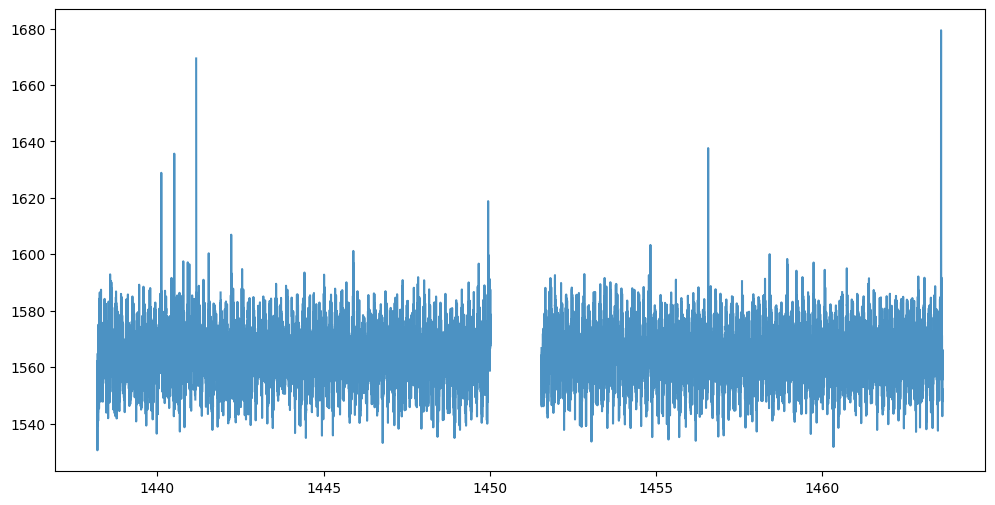

In [36]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
# plt.plot(lc_fill.index, model_tbats.y_hat, label='In-sample preds', linestyle='--', color='purple')
plt.plot(lc_fill, label='Original', alpha=0.8)
plt.plot(lc_fill.index, model_auto.predict_in_sample(exog), label='In-sample preds', color='red')
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
plt.axvline(lc_fill.index.max(), color = "grey")
plt.axvline(lc_fill.index.min(), color = "grey")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
# plt.xlim((1440, 1441))
plt.show()

In [28]:
print(model_tbats.aic)
print(model_auto.aic())

252868.10479599182
126649.52854652634


In [84]:
a = null_indices[null_indices >= 1450].min()
# np.where(lc_fill.index >= 1451)[0]
b = lc_fill.iloc[np.where(lc_fill.index >= 1451)[0]].dropna().index.min()
print((a, b))

np.where(lc_fill.index == b)[0][0] - np.where(lc_fill.index == a)[0][0]

print(exog.tail())

(1450.0230268383614, 1451.5549590647147)
             FOURIER_S240-0  FOURIER_C240-0
time                                       
1463.617418       -0.382671        0.923885
1463.618806       -0.358356        0.933585
1463.620195       -0.333794        0.942646
1463.621584       -0.309004        0.951061
1463.622973       -0.284003        0.958824


In [91]:
y_prime.loc[:a]

,pdcsap_flux
1438.198088,1561.99320
1438.199477,1530.50820
1438.200866,1534.73300
1438.202255,1558.94310
1438.203644,1553.72030
...,...
1450.017471,1570.61070
1450.018860,1578.59180
1450.020249,1571.97120
1450.021638,1567.72330


Performing stepwise search to minimize aic
 ARIMA(12,0,0)(0,0,0)[0] intercept   : AIC=59600.027, Time=2.99 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=61673.127, Time=0.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=61708.777, Time=2.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60932.830, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=216006.579, Time=0.13 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=59555.327, Time=22.85 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=59605.529, Time=2.35 sec
 ARIMA(11,0,1)(0,0,0)[0] intercept   : AIC=59554.197, Time=24.86 sec
 ARIMA(10,0,1)(0,0,0)[0] intercept   : AIC=59570.627, Time=20.47 sec
 ARIMA(12,0,1)(0,0,0)[0] intercept   : AIC=59548.034, Time=26.27 sec
 ARIMA(13,0,1)(0,0,0)[0] intercept   : AIC=59523.470, Time=29.74 sec
 ARIMA(13,0,0)(0,0,0)[0] intercept   : AIC=59541.685, Time=29.93 sec
 ARIMA(14,0,1)(0,0,0)[0] intercept   : AIC=59553.255, Time=36.65 sec
 ARIMA(13,0,2)(0,0,0)[0] intercept   : AIC=59571.441, Time=32.79 sec


ValueError: X array dims (n_rows) != n_periods. Received n_rows=1102 and n_periods=1101

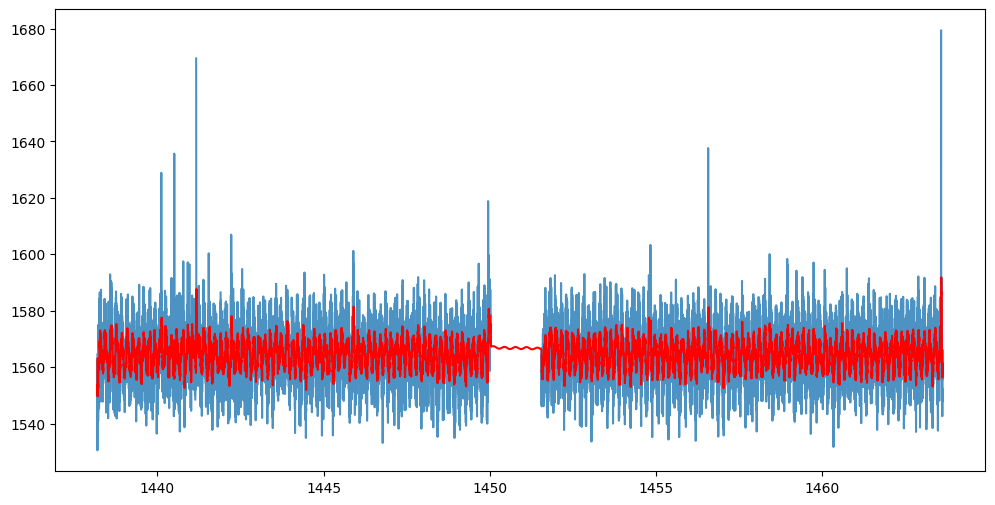

In [ ]:
## FORECAST IMPUTE ##
lc_interp = lc_fill.interpolate(method='pchip')
pred_len = 1101

## Auto ARIMA
warnings.filterwarnings("ignore")
model_tmp = auto_arima(
    y_prime.loc[:a],
    X=exog.loc[:a],
    start_p = 12, start_q = 0,
    max_p = 20, max_q = 20,
    trace=True,
    error_action='ignore'
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

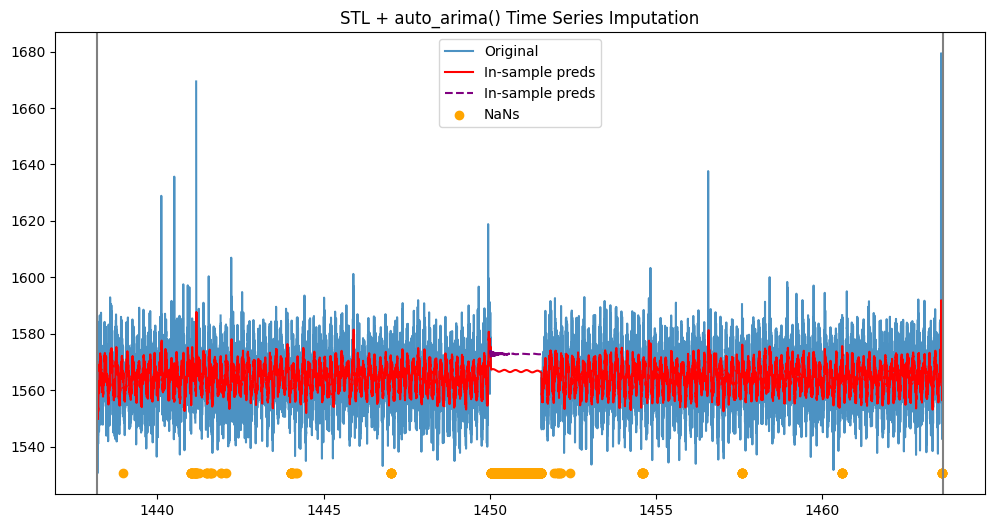

In [ ]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
# plt.plot(lc_fill.index, model_tbats.y_hat, label='In-sample preds', linestyle='--', color='purple')
plt.plot(lc_fill, label='Original', alpha=0.8)
plt.plot(lc_fill.index, model_auto.predict_in_sample(exog), label='In-sample preds', color='red')
plt.plot(lc_interp.loc[a:b].head(pred_len).index, model_tmp.predict_in_sample(), label='In-sample preds', linestyle='--', color='purple')
plt.plot(lc_interp.loc[a:b].head(pred_len).index, model_tmp.predict(pred_len, X=exog.loc[a:b].head(pred_len)), label='In-sample preds', linestyle='--', color='purple')
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
plt.axvline(lc_fill.index.max(), color = "grey")
plt.axvline(lc_fill.index.min(), color = "grey")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
# plt.xlim((1440, 1441))
plt.show()

             pdcsap_flux
1438.198088    1561.9932
1438.199477    1530.5082
1438.200866    1534.7330
1438.202255    1558.9431
1438.203644    1553.7203
             FOURIER_S240-0  FOURIER_C240-0
time                                       
1438.198088        0.026177        0.999657
1438.199477        0.052336        0.998630
1438.200866        0.078459        0.996917
1438.202255        0.104528        0.994522
1438.203644        0.130526        0.991445
((19329, 1), (19329, 2))


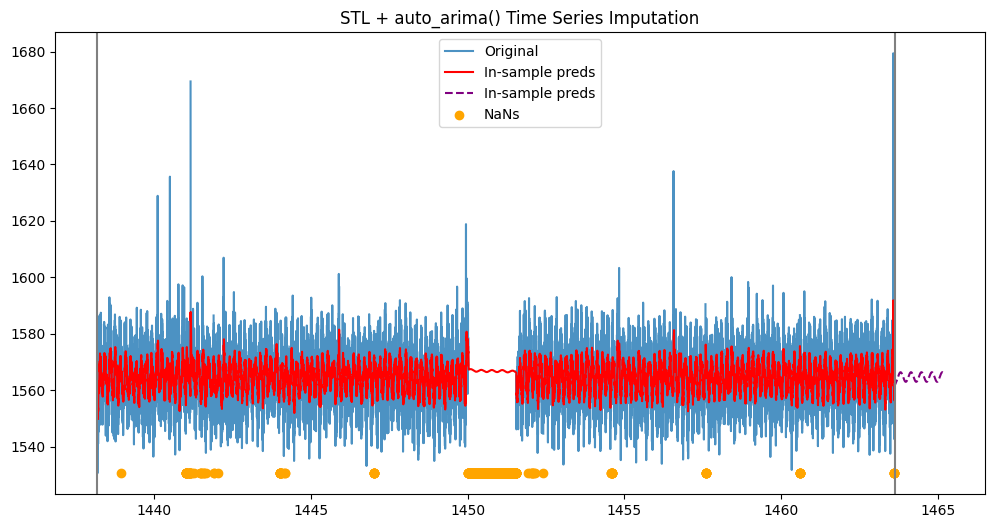

In [ ]:
# ## FORECAST ##
# lc_interp = lc_fill.interpolate(method='pchip')
# pred_len = 1101
# time_diffs = lc_interp.index.to_series().diff()
# med = time_diffs.median()
# new_inds = np.arange(start = lc_interp.index.max() + med, stop = lc_interp.index.max() + med * pred_len, step = med)
# new_rows = pd.DataFrame({lc_interp.columns[0]: np.nan}, index = new_inds)
# lc_interp = pd.concat([lc_interp, new_rows])
# lc_interp.shape

# ## Fourier terms
# fourier_terms = FourierFeaturizer(240, four_order)
# y_prime, exog = fourier_terms.fit_transform(lc_interp)
# exog['time'] = y_prime.index # is exactly the same as manual calculation in the above cells
# exog = exog.set_index(exog['time'])
# exog = exog.drop(columns=['time'])
# print(y_prime.head()); print(exog.head())
# print((y_prime.shape, exog.shape))

# ## Check
# # Plot original vs imputed series
# plt.figure(figsize=(12,6))
# # plt.plot(lc_fill.index, model_tbats.y_hat, label='In-sample preds', linestyle='--', color='purple')
# plt.plot(lc_fill, label='Original', alpha=0.8)
# plt.plot(lc_fill.index, model_auto.predict_in_sample(exog), label='In-sample preds', color='red')
# plt.plot(lc_interp.index[-pred_len:], model_auto.predict(pred_len, X=exog.tail(pred_len)), label='In-sample preds', linestyle='--', color='purple')
# plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
# plt.axvline(lc_fill.index.max(), color = "grey")
# plt.axvline(lc_fill.index.min(), color = "grey")
# plt.title("STL + auto_arima() Time Series Imputation")
# plt.legend()
# # plt.xlim((1440, 1441))
# plt.show()

In [ ]:
# def sarima_impute():
#     ## 

#     return 1

In [29]:
## IMPUTE ##
model = model_auto

d = model.order[1]
pred_vals = model.predict_in_sample(exog)
lc_fill.loc[null_indices[np.isin(null_indices, lc_fill.index[d:])], "pdcsap_flux"] = pred_vals[np.isin(lc_fill.index[d:], null_indices)] 

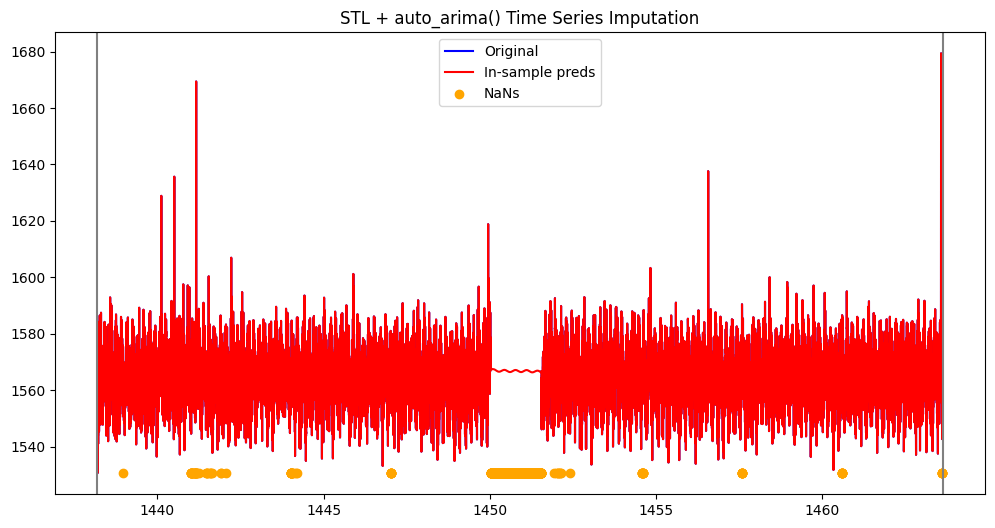

In [40]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', color='blue')
plt.plot(lc_fill, label='In-sample preds', color='red')
plt.scatter(null_indices, np.full(len(null_indices), lc_fill.min()), label='NaNs', color='orange')
plt.axvline(lc_fill.index.max(), color = "grey")
plt.axvline(lc_fill.index.min(), color = "grey")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
# plt.xlim((1440, 1441))
plt.show()

In [31]:
## Check
print(lightcurve.describe())
print(lc_fill.describe())
lc_fill.info()

        pdcsap_flux
count  17033.000000
mean    1564.459684
std        9.316531
min     1530.508200
25%     1558.114900
50%     1564.397800
75%     1570.626300
max     1679.386400
        pdcsap_flux
count  18229.000000
mean    1564.609604
std        9.032917
min     1530.508200
25%     1558.666700
50%     1565.153300
75%     1570.183000
max     1679.386400
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  18229 non-null  float64
dtypes: float64(1)
memory usage: 800.9 KB


In [ ]:
## Save model
# filename = "sarima_model.sav"
# pickle.dump(model_auto, open(filename, 'wb'))

# ## Open model
# loaded_model = pickle.load(open(filename, 'rb'))

# STL Decomposition

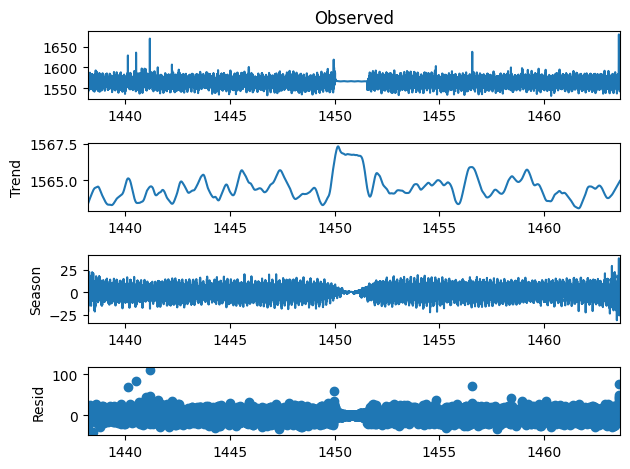

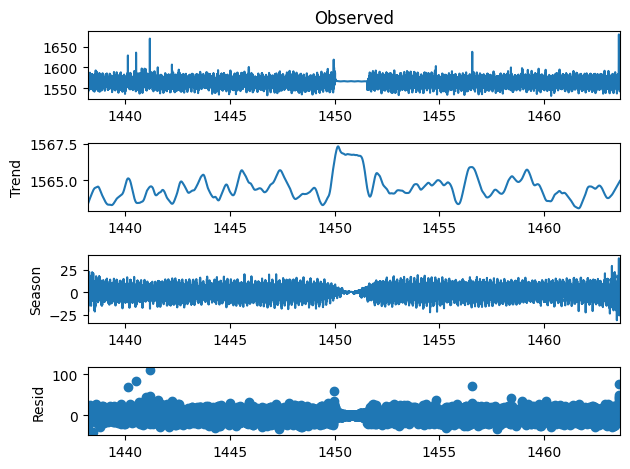

In [41]:
## STL Decomposition
stl = STL(lc_fill, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## Plot
decomposition.plot()

In [42]:
# Check
residual.info(); residual.head(); residual.describe()

<class 'pandas.core.series.Series'>
Float64Index: 18229 entries, 1438.198088310551 to 1463.6229730857283
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
18229 non-null  float64
dtypes: float64(1)
memory usage: 800.9 KB


count    18229.000000
mean         0.084108
std          6.711376
min        -41.444380
25%         -3.106505
50%         -0.012013
75%          3.185056
max        109.397990
Name: resid, dtype: float64

In [43]:
## Save the imputed dataset
lc_fill["pdcsap_clean"] = residual #pdcsap_imputed
lc_fill["trend"] = trend
lc_fill["seasonal"] = seasonal
lc_fill.to_csv("../0.Data/031381302_imputed.csv")

KeyError: 'pdcsap_clean'

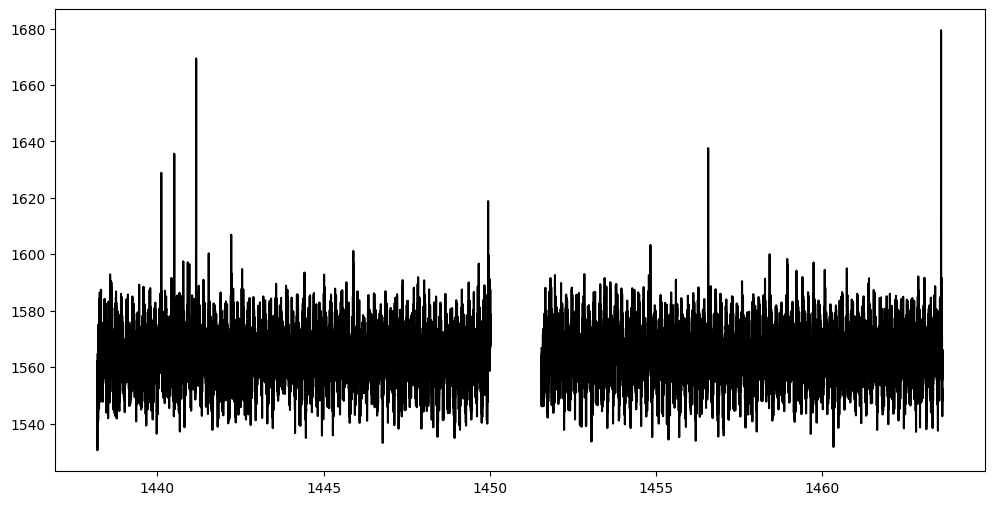

In [68]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', color = "black")
plt.plot(lc_fill["pdcsap_clean"] + trend.mean(), label='Imputed (auto_arima)', linestyle='--', color = "steelblue", alpha = 0.8)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

# Plot imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_fill["pdcsap_clean"], label='Imputed (auto_arima)', color = "steelblue")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()